In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

<b>Load ORL dataset and convert into numpy arrays

In [2]:
orl_path = "ORL"

img = []
labels = []

for cls, person_folder in enumerate(sorted(os.listdir(orl_path))):
    person_folder_path = os.path.join(orl_path, person_folder)
    if not os.path.isdir(person_folder_path):
        continue

    for file_name in os.listdir(person_folder_path):
        if file_name.lower().endswith(('.bmp')):
            image_path = os.path.join(person_folder_path, file_name)

            image = Image.open(image_path).convert("L").resize((46,56))
            image_array = np.array(image).flatten()
            img.append(image_array)
            labels.append(cls)

X = np.array(img, dtype=np.float32)
y = np.array(labels)           

<b>Normalization for easier computation

In [3]:
X_norm = X / 255.0

<b>No. of components vs varinace ratio for diffrent train test split

In [4]:
Variance_ratio= [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5]
test_sizes = [0.5, 0.4, 0.3, 0.2, 0.1]

results = pd.DataFrame(index=Variance_ratio)

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=test_size, random_state=42, shuffle=True, stratify=y)
    pca_split = PCA().fit(X_train)
    cumulative_variance = np.cumsum(pca_split.explained_variance_ratio_) * 100
    
    col_name = f"train / test {int((1-test_size)*100)}% / {int((test_size)*100)}%"
    results[col_name] = [ np.argmax(cumulative_variance >= F) + 1 for F in Variance_ratio]

results.index.name = "Variance ratio (%)"
results.columns.name = "No. of components:"

display(results)

No. of components:,train / test 50% / 50%,train / test 60% / 40%,train / test 70% / 30%,train / test 80% / 20%,train / test 90% / 10%
Variance ratio (%),,,,,
83.0,34,36,37,38,39
84.0,36,38,40,41,43
85.0,39,42,43,45,46
86.0,42,45,47,49,50
87.0,45,49,51,53,55
88.0,49,53,56,58,60
89.0,53,58,61,63,66
90.0,58,63,67,70,73
91.0,63,69,74,77,81


<b>Plotting the results

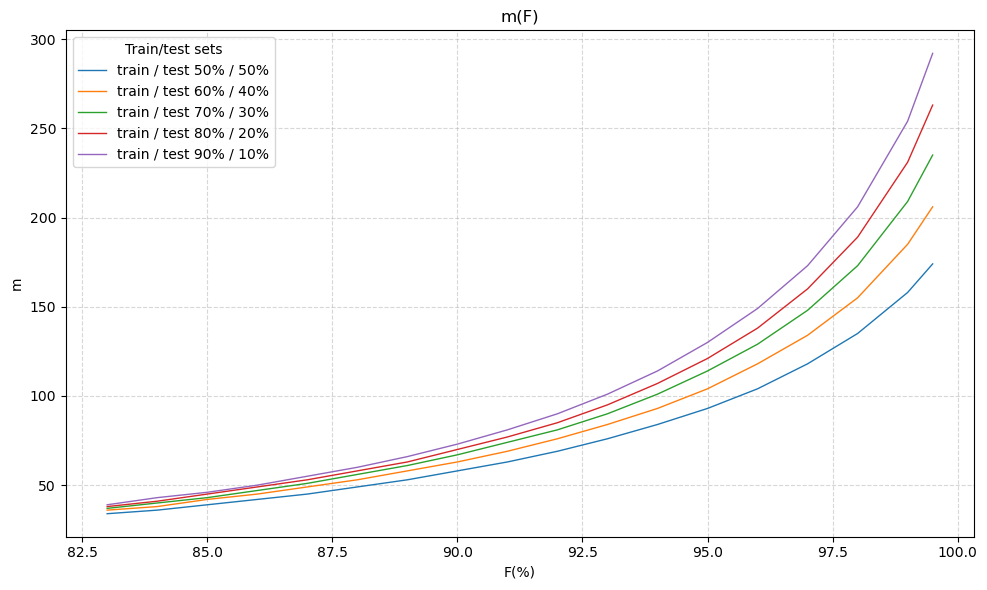

In [5]:
plt.figure(figsize=(10,6))

for col in results.columns:
    plt.plot(results.index, results[col], label=col, linewidth=1)

plt.title("m(F)")
plt.xlabel("F(%)")
plt.ylabel("m")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Train/test sets")
plt.tight_layout()
plt.show()

<b>Splitting the dataset into training set and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(280, 2576) (120, 2576) (280,) (120,)


<b>Plotting first 2 principal components

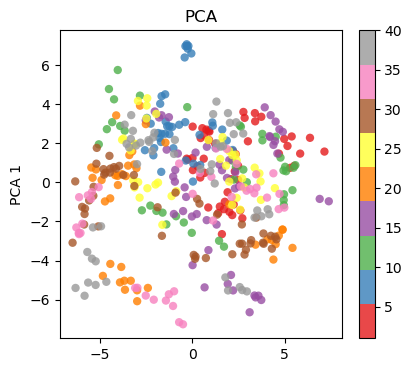

In [7]:
pca_embd = PCA(n_components=2).fit(X_norm)
X_embedded = pca_embd.transform(X_norm)

plt.figure(figsize=(10,4))

plt.subplot(1,2,2)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y, edgecolor="none", alpha=0.8, cmap=plt.colormaps["Set1"])
plt.ylabel("PCA 2")
plt.ylabel("PCA 1")
plt.title("PCA")

plt.colorbar()

plt.show()

<b>Define the classifiers

In [8]:
nn = KNeighborsClassifier(n_neighbors=1)
knn = KNeighborsClassifier(n_neighbors=3)
nc = NearestCentroid()

models = [( "Nearest Neighbors", nn), ( "3 Nearest Neighbors", knn), ( "Nearest Prototype", nc)]

<b> Selecting the optimal number of principal components

In [10]:
pca_full = PCA().fit(X_train)

m_components = results["train / test 70% / 30%"].astype(int).tolist()
df_accuracy = pd.DataFrame(index=m_components)

for name,model in models:
    rows = []
    for m in m_components:
        X_train_pca = pca_full.transform(X_train)[:, :m]
        X_test_pca = pca_full.transform(X_test)[:, :m]
        
        model.fit(X_train_pca, y_train)
        accuracy = model.score(X_test_pca, y_test)
        
        rows.append(round(accuracy,2))
    df_accuracy[name] = rows
df_accuracy.index.name = "m"
df_accuracy.columns.name = "Accuracy (%):"
display(df_accuracy)

Accuracy (%):,Nearest Neighbors,3 Nearest Neighbors,Nearest Prototype
m,,,
37,0.95,0.90,0.90
40,0.97,0.89,0.90
43,0.97,0.88,0.90
47,0.96,0.88,0.90
51,0.96,0.88,0.91
56,0.96,0.90,0.90
61,0.95,0.89,0.91
67,0.95,0.91,0.91
74,0.96,0.89,0.92


<b>Plotting the results

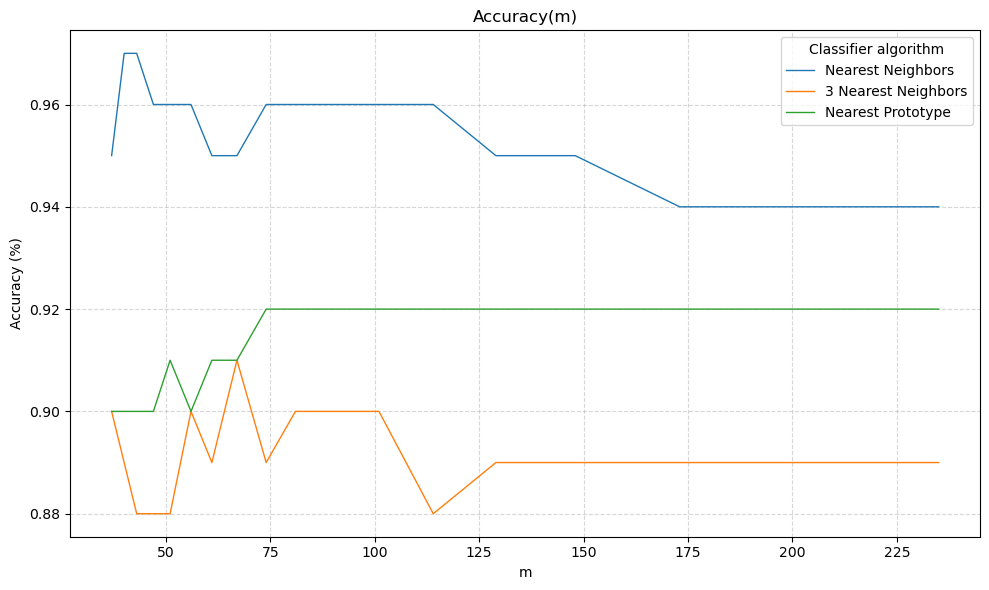

In [11]:
plt.figure(figsize=(10,6))

for col in df_accuracy.columns:
    plt.plot(df_accuracy.index, df_accuracy[col], label=col, linewidth=1)

plt.title("Accuracy(m)")
plt.xlabel("m")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Classifier algorithm")
plt.tight_layout()
plt.show()

<b>Plotting the first 10 eigenfaces/components

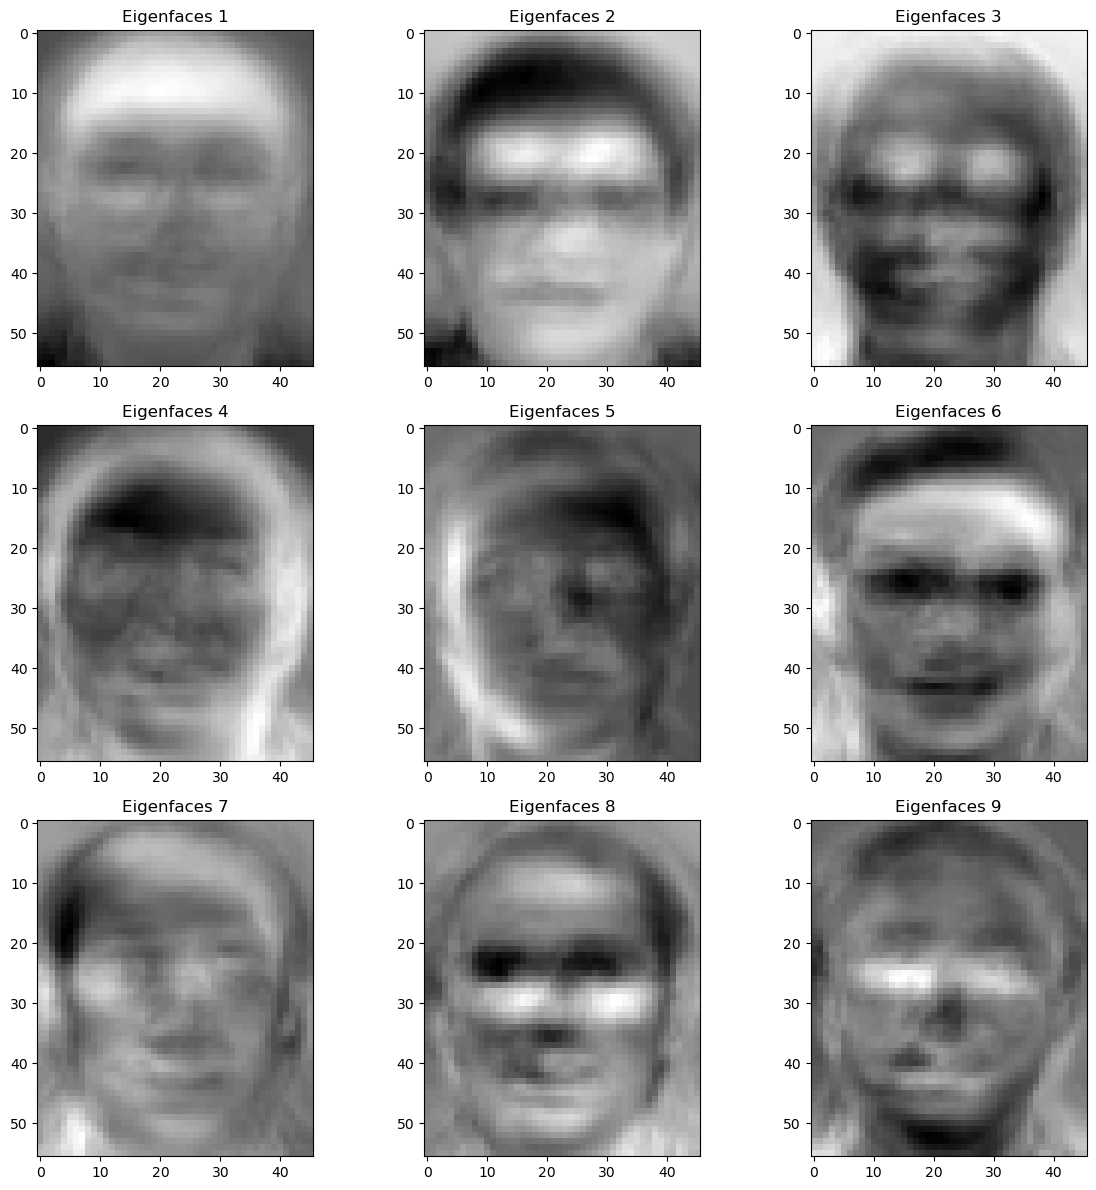

In [12]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(pca_full.components_[i].reshape(56,46), cmap='gray')
    plt.title("Eigenfaces "+ str(i+1))
plt.tight_layout()
plt.show()

<b>Models performance evaluation

Performance metrics (m = 81),Nearest Neighbors,3 Nearest Neighbors,Nearest Prototype
Accuracy score,0.96,0.90,0.92
Precision score,0.97,0.93,0.94
Recall score,0.96,0.90,0.92
F1-score,0.95,0.90,0.91


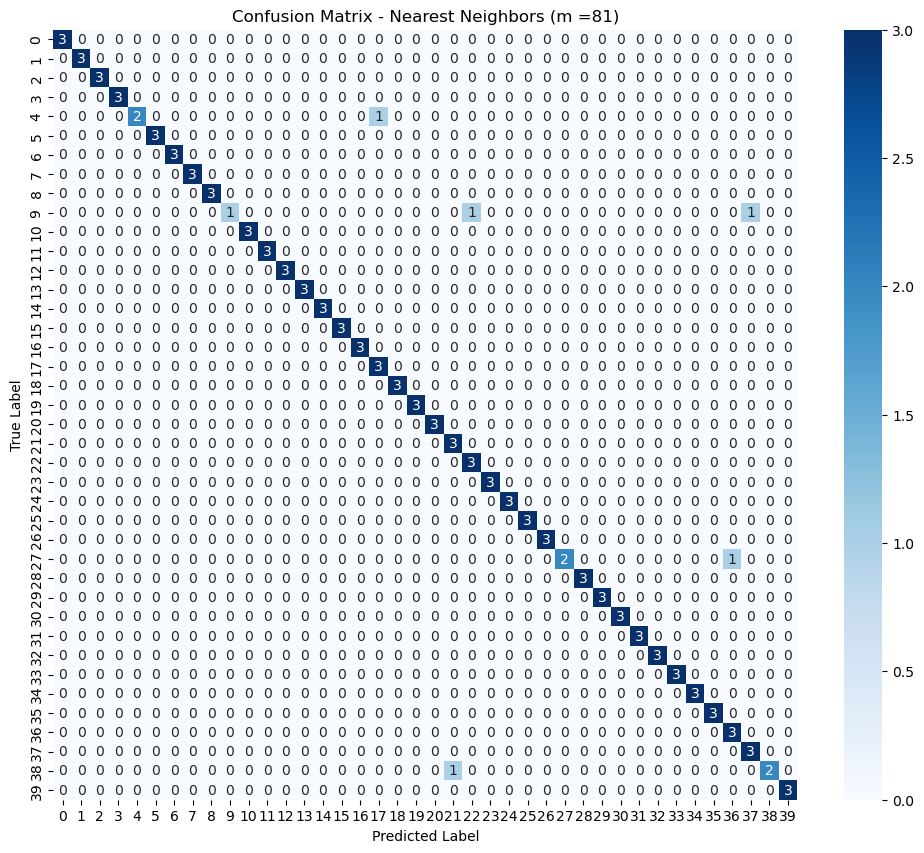

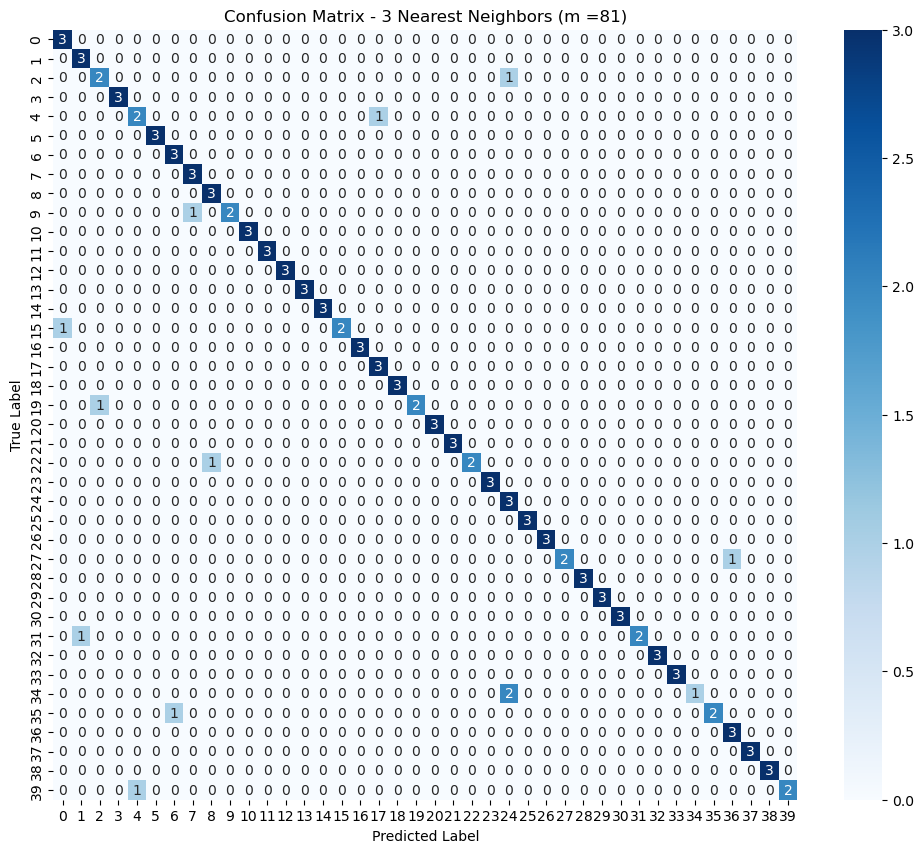

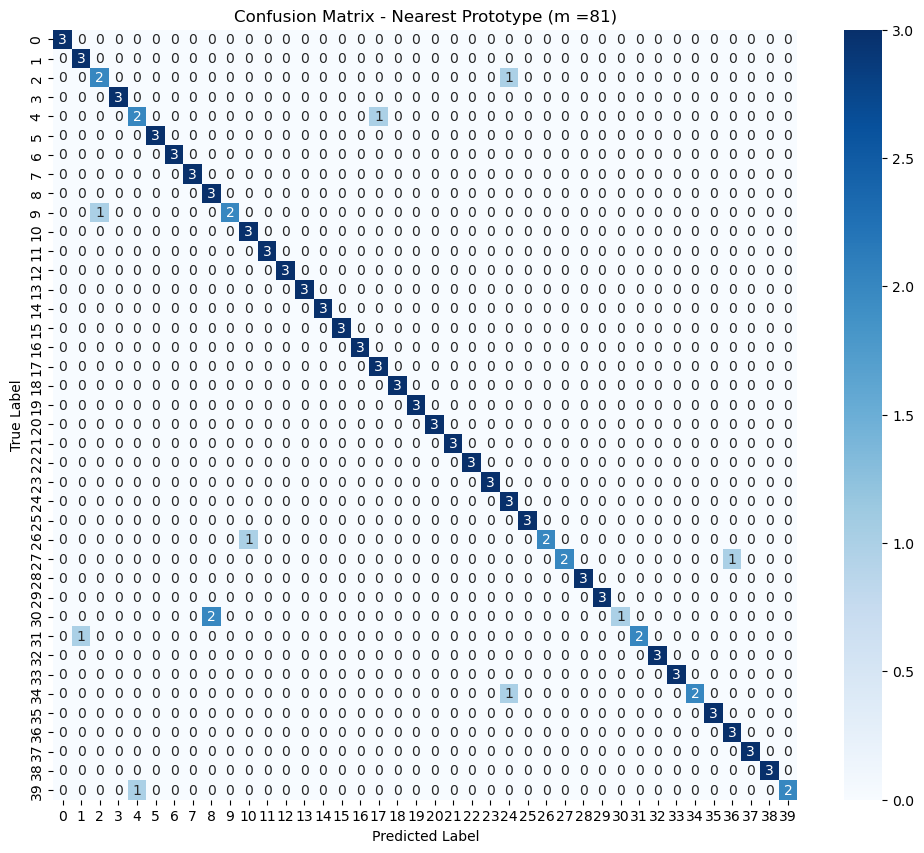

In [13]:
m = 81
cms = []   
metrics_df = pd.DataFrame(index=["Accuracy score", "Precision score", "Recall score", "F1-score"])

for name,model in models:
    X_train_pca = pca_full.transform(X_train)[:, :m]
    X_test_pca = pca_full.transform(X_test)[:, :m]
        
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    metrics_df.loc["Accuracy score", name] = round(accuracy,2)
    metrics_df.loc["Precision score", name] = round(precision,2)
    metrics_df.loc["Recall score", name] = round(recall,2)
    metrics_df.loc["F1-score", name] = round(f1,2)
    
    cm = confusion_matrix(y_test, y_pred)
    cms.append((name,cm))

metrics_df.columns.name = f"Performance metrics (m = {m})"
display(metrics_df)

for name, cm in cms:
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"Confusion Matrix - {name} (m ={m})")
    plt.show()
    